In [1]:
from collections import defaultdict
import numpy as np
import pdb
from sklearn.datasets.samples_generator import make_blobs
from itertools import combinations, product
from scipy.special import gamma
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
def volume(r, m):
    return np.pi ** (m / 2) * r ** m / gamma(m / 2 + 1)

def significant(cluster, h, p):
    max_diff = max(abs(p[i] - p[j]) for i, j in product(cluster, cluster))
    return max_diff >= h

def get_clustering(x, k, h):
    n = len(x)
    m = len(x[0])
    dist = squareform(pdist(x))

    dk = []
    for i in range(n):
        order = list(range(n))
        order.sort(key=lambda j: dist[i][j])
        dk.append(dist[i][order[k - 1]])

    p = [k / (volume(dk[i], m) * n) for i in range(n)]

    w = np.full(n, 0)
    completed = {0: False}
    last = 1
    vertices = set()
    for d, i in sorted(zip(dk, range(n))):
        neigh = set()
        neigh_w = set()
        clusters = defaultdict(list)
        for j in vertices:
            if dist[i][j] <= dk[i]:
                neigh.add(j)
                neigh_w.add(w[j])
                clusters[w[j]].append(j)

        vertices.add(i)
        if len(neigh) == 0:
            w[i] = last
            completed[last] = False
            last += 1
        elif len(neigh_w) == 1:
            wj = next(iter(neigh_w))
            if completed[wj]:
                w[i] = 0
            else:
                w[i] = wj
        else:
            if all(completed[wj] for wj in neigh_w):
                w[i] = 0
                continue
            significant_clusters = set(wj for wj in neigh_w if significant(clusters[wj], h, p))
            if len(significant_clusters) > 1:
                w[i] = 0
                for wj in neigh_w:
                    if wj in significant_clusters:
                        completed[wj] = (wj != 0)
                    else:
                        for j in clusters[wj]:
                            w[j] = 0
            else:
                if len(significant_clusters) == 0:
                    s = next(iter(neigh_w))
                else:
                    s = next(iter(significant_clusters))
                w[i] = s
                for wj in neigh_w:
                    for j in clusters[wj]:
                        w[j] = s
    return w

In [3]:
iris = datasets.load_iris()
x = iris.data
y = iris.target
w = get_clustering(x, 11, 0.05)

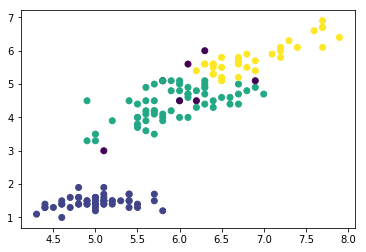

In [4]:
plt.scatter(x[:, 0], x[:, 2], c=w)

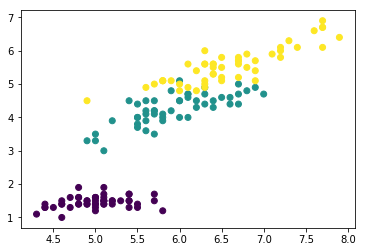

In [5]:
plt.scatter(x[:, 0], x[:, 2], c=y)

In [6]:
# Источник: https://matplotlib.org/3.1.0/gallery/mplot3d/lorenz_attractor.html

import numpy as np
import matplotlib.pyplot as plt


def lorenz(x, y, z, s=10, r=28, b=2.667):
    '''
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    '''
    x_dot = s * (y - x)
    y_dot = r * x - y - x * z
    z_dot = x * y - b * z
    return x_dot, y_dot, z_dot


dt = 0.01
num_steps = 10000

# Need one more for the initial values
xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)

# Set initial values
xs[0], ys[0], zs[0] = (0., 1., 1.05)

# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)

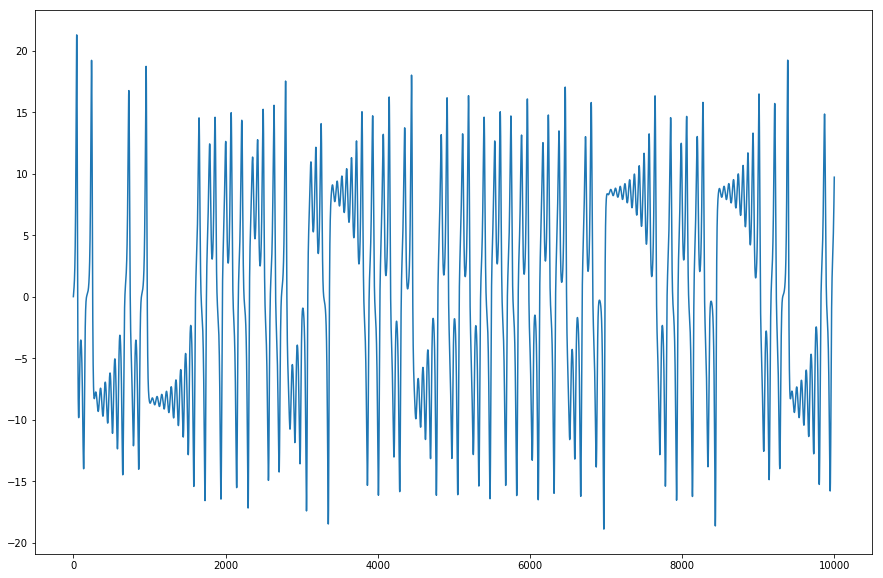

In [7]:
plt.figure(figsize=(15, 10))
plt.plot(xs)

In [8]:
train_beg = 4800
train_end = 6000
test_end = 7000

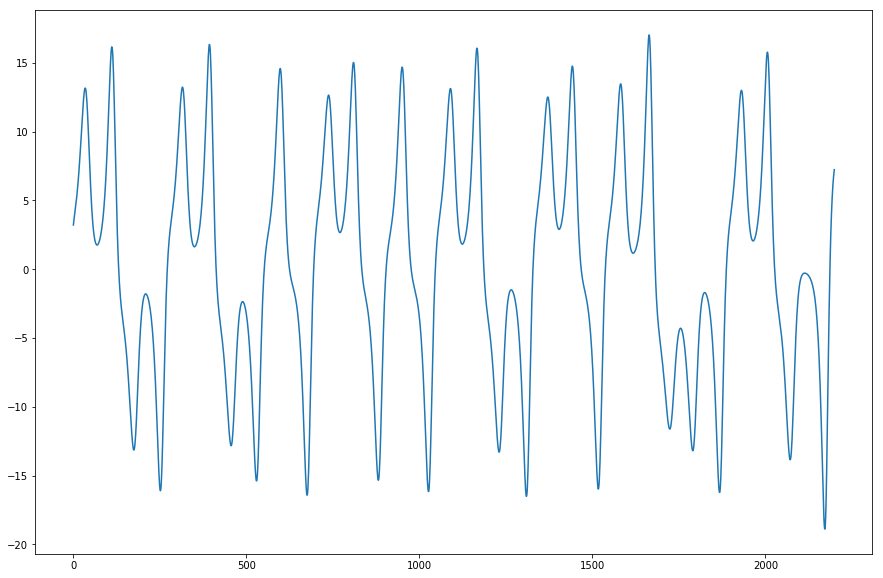

In [9]:
plt.figure(figsize=(15, 10))
plt.plot(xs[train_beg:test_end])

In [10]:
train_x = [[xs[i], xs[i + 1], xs[i + 2], xs[i + 3]] for i in range(train_beg, train_end - 4)]
test_x = [[xs[i], xs[i + 1], xs[i + 2], xs[i + 3]] for i in range(train_end, test_end - 4)]

In [11]:
w = get_clustering(train_x, 11, 0.2)

In [12]:
len(np.unique(w))

20

In [13]:
from itertools import groupby

centers = []
sorted_by_cluster = sorted(range(len(w)), key=lambda x: w[x])
for wi, cluster in groupby(sorted_by_cluster, lambda x: w[x]):
    cluster = list(cluster)
    center = np.full(4, 0.0)
    for i in cluster:
        center += train_x[i]
    centers.append(center / len(cluster))

In [14]:
from scipy.spatial import distance

predicitons = []
for i in range(len(test_x)):
    best_dist = 1e9
    for center in centers:
        if distance.euclidean(test_x[i][:-1], center[:-1]) < best_dist:
            best_dist = distance.euclidean(test_x[i][:-1], center[:-1])
            best_center = center
    predicitons.append(best_center[-1])

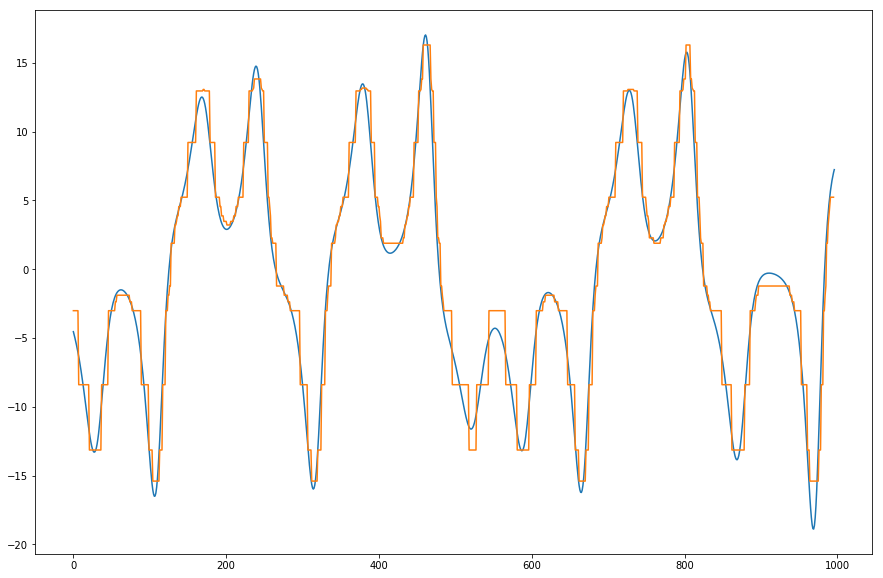

In [15]:
plt.figure(figsize=(15, 10))
plt.plot(xs[train_end + 3:test_end])
plt.plot(predicitons)